# Research notebook
## Topic modeling of twitter data

### Importing the libraries necessary for the work

In [1]:
import pandas as pd
import nltk
import gensim
import re
from textblob import TextBlob 
import sklearn
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sent2vec.vectorizer import Vectorizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score
transformation = SentenceTransformer('all-MiniLM-L6-v2')
stp = stopwords.words('english')

### Reading the csv files and merging all the tweets in one big frame

In [2]:
def read(name, party):
    frame = pd.read_excel(f'./data_twitter/tweets_{party}/@{name}_user_tweets.xlsx')
    frame = frame[['Screen Name', 'Text']]
    frame['Text'] = frame['Text'].apply(lambda x: x if x[0:2]!='RT' else '')
    frame = frame[frame['Text']!='']
    frame = frame.reset_index(drop=True)
    return frame

list_politicians_right = ['benshapiro','dineshdsouza','jordanbpeterson','MattWalshBlog', 'michaeljknowles',
                         'randpaul','RealCandaceO', 'realdonaldtrump','SenTedCruz', 'gop']

list_politicians_left = ['aoc', 'barackobama', 'berniesanders', 'billmaher', 'ggreenwald', 'IlhanMN',
                        'joebiden', 'kamalaharris', 'senwarren', 'cnn', 'aliciagarza']

frame_r = []
frame_l = []

# political tweets from the right
for name in list_politicians_right:
    frame_r.append(read(name, 'right'))

# political tweets from the left
for name in list_politicians_left:
    frame_l.append(read(name, 'left'))

In [3]:
frame_r
for frame in frame_r:
    frame['party']='right'

frame_l
for frame in frame_l:
    frame['party']='left'

# merging all the tweets from the right in one frame
frame_l.extend(frame_r)
frames = frame_l

# merging all the tweets from the right in one frame
frame = pd.concat(frames, axis=0)
frame.reset_index(inplace=True)
frame = frame.drop(columns=['index'])

### Vizualizing the pandas frame used to work 

In [4]:
frame

,Screen Name,Text,party
0,AOC,@Welcome2theBX @KathyHochul Thank you! We are ...,left
1,AOC,@SimBreezay @thop25 Yes! Keep an eye out for t...,left
2,AOC,@thop25 The way we are handling it in NYC isn’...,left
3,AOC,You can read more about it here: https://t.co/...,left
4,AOC,Did you know that ongoing exposure to NO2 from...,left
...,...,...,...
46776,GOP,Latinos are moving in droves to the Republican...,right
46777,GOP,Republican turnout in Pennsylvania has already...,right
46778,GOP,Republican @GovernorLittle wins the Republican...,right
46779,GOP,Cheers to @Castelli4NC on winning North Caroli...,right


### Cleaning the tweets 

In [5]:
lemmatizer = WordNetLemmatizer()

def clean_stage1(text):
     
    li =['ð','Ÿ','‡','º','€','™','”','–','n\'t','¦','$','%','’','“', '!', '\?', '\[', '\]', '‘', '&amp', '—', '-','…', '––']     
    numbers = '1234567890'
    '''
    get things in lower case,
    remove a weird character in the data,
    remove stuff in parenthesis as well as brackets,
    remove stuff after punctuations,
    remove weird characters like @ or #,
    remove backslach,
    remove trailing space,
    remove the at in the name,
    replace the double space by monospace.
    '''
    stp = list(stopwords.words('english'))
    text = text.lower()
    ''' replace weird characters and stop words'''
    for el in li:
        text = re.sub(el, ' ', text)
    ''' replace numbers '''
    for n in numbers:
        text = re.sub(n, '', text)
    text = re.sub(r'https\S+', '', text)
    text = re.sub('@\S+', '', text)
    text = re.sub(r'www\s+', ' ', text)
    text = re.sub('//', ' ', text)
    text = re.sub('\(.*?\)+|\(.*', ' ', text)
    text = re.sub(',.*|\-.*', ' ', text)
    text = re.sub(r'\\.*', ' ', text)
    text = re.sub('\)', ' ', text)
    text = re.sub('\n|-', ' ', text)
    text = re.sub('\s+$', ' ', text)
    text = re.sub('^[ \t]+', ' ', text)
    text = re.sub('\"', ' ', text)
    arr = text.split(' ')
    arr_ = []
    for i in range(len(arr)):
        arr_.append(lemmatizer.lemmatize(arr[i]))
    text =' '.join(arr_)
    text = re.sub('  ', ' ', text)
    return text.strip()

In [6]:
def clean_stage3(text):
    text = '' if len(text.split(' '))<4 else text
    text = ' '.join([w for w in text.split(' ') if len(w)>=4])
    return text

frame['Text'] = frame['Text'].apply(lambda x: clean_stage3(x))

In [7]:
frame['Text'] = frame['Text'].apply(lambda x: clean_stage1(x))
frame = frame.loc[frame['Text']!='']
frame.reset_index(inplace=True, drop=True)

In [8]:
frame

,Screen Name,Text,party
0,AOC,thank you securing similar pedestrian investme...,left
1,AOC,yes keep credits/rebates gas free appliance th...,left
2,AOC,handling isn t force people switch what they a...,left
3,AOC,read more about here:,left
4,AOC,know that ongoing exposure from stove linked r...,left
...,...,...,...
44522,GOP,latino moving drove republican party. this eff...,right
44523,GOP,republican turnout pennsylvania already outper...,right
44524,GOP,republican win republican primary idaho conser...,right
44525,GOP,cheer winning north carolina s congressional p...,right


### Vectorizing the tweets using the sent2vec library

In [9]:
vectors = transformation.encode(frame['Text'])

### Running the k mean clustering algorithm to find the topics

In [10]:
k = 20
model = KMeans(n_clusters=k, init='k-means++', max_iter=100000, n_init=10)
model.fit(vectors)

KMeans(max_iter=100000, n_clusters=20)

In [11]:
frame['cluster'] = model.labels_

C:\Users\BROWDERKD20\AppData\Local\Temp\ipykernel_1532\1404149975.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['cluster'] = model.labels_


In [12]:
frame

,Screen Name,Text,party,cluster
0,AOC,thank you securing similar pedestrian investme...,left,12
1,AOC,yes keep credits/rebates gas free appliance th...,left,11
2,AOC,handling isn t force people switch what they a...,left,17
3,AOC,read more about here:,left,0
4,AOC,know that ongoing exposure from stove linked r...,left,15
...,...,...,...,...
44522,GOP,latino moving drove republican party. this eff...,right,3
44523,GOP,republican turnout pennsylvania already outper...,right,3
44524,GOP,republican win republican primary idaho conser...,right,6
44525,GOP,cheer winning north carolina s congressional p...,right,3


In [13]:
def get_topic(val):
    arr_test = frame['Text'].loc[frame['cluster']==val].values[0:100]
    corpus = ';'.join(arr_test)
    corpus = TextBlob(corpus)
    freq = []
    collection = set(corpus.words)
    main=''
    count = 0
    for word in collection:
        if word not in stp: 
            c = corpus.word_counts[word]
            freq.append((word,c))
            if c> count:
                count = c
                main = word
    freq.sort(key=lambda a: a[1], reverse=True)
    return freq

In [14]:
f = open('topic_modeling.txt', 'w', encoding='utf8')

for i in range(k):
    arr = get_topic(i)
    f.write(f' Topic # {i} = {arr[0][0]}')
    f.write('\n')
    for el in arr:
        f.write(str(el))
        f.write('\n')

f.close()

In [15]:
frame

,Screen Name,Text,party,cluster
0,AOC,thank you securing similar pedestrian investme...,left,12
1,AOC,yes keep credits/rebates gas free appliance th...,left,11
2,AOC,handling isn t force people switch what they a...,left,17
3,AOC,read more about here:,left,0
4,AOC,know that ongoing exposure from stove linked r...,left,15
...,...,...,...,...
44522,GOP,latino moving drove republican party. this eff...,right,3
44523,GOP,republican turnout pennsylvania already outper...,right,3
44524,GOP,republican win republican primary idaho conser...,right,6
44525,GOP,cheer winning north carolina s congressional p...,right,3


Text(0.5, 1.0, 'Distribution of tweets over clusters')

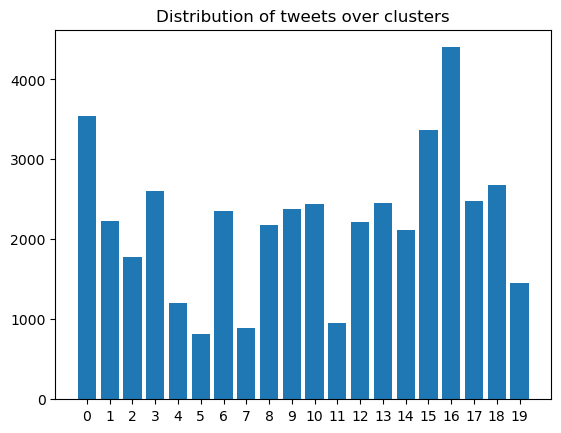

In [16]:
li = frame.groupby(['cluster'])['Text'].count().values
clusters = list(range(20))
plt.bar(range(len(li)), li, tick_label=clusters)
plt.title('Distribution of tweets over clusters')

Text(0.5, 1.0, 'Distribution of tweets over clusters for left')

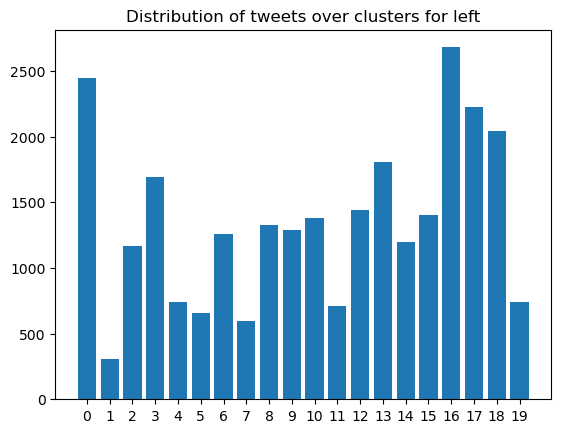

In [17]:
left_li = frame.groupby(['party', 'cluster'])['Text'].count().values[0:20]
clusters = list(range(20))
plt.bar(range(len(left_li)), left_li, tick_label=clusters)
plt.title('Distribution of tweets over clusters for left')

Text(0.5, 1.0, 'Distribution of tweets over clusters for right')

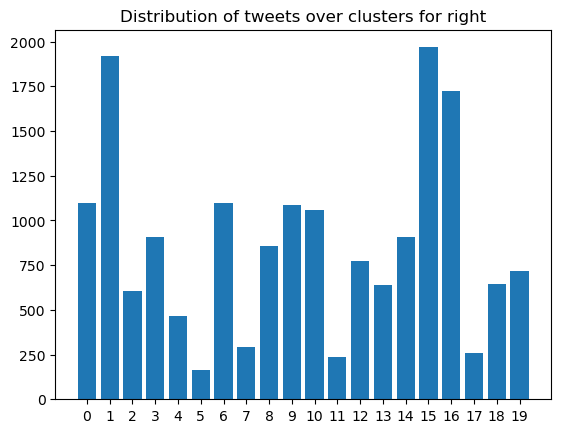

In [18]:
right_li = frame.groupby(['party', 'cluster'])['Text'].count().values[20:]
clusters = list(range(20))
plt.bar(range(len(right_li)), right_li, tick_label=clusters)
plt.title('Distribution of tweets over clusters for right')

In [40]:
right_li

array([ 767,  928, 1894, 2327,  391,  872,  170, 1083, 1273,  685,  581,
        637, 1023,  752,  729,  350,  986,  269, 1055,  642], dtype=int64)

## Attempt to classify tweets
### Distribution of tweets per cluster per party

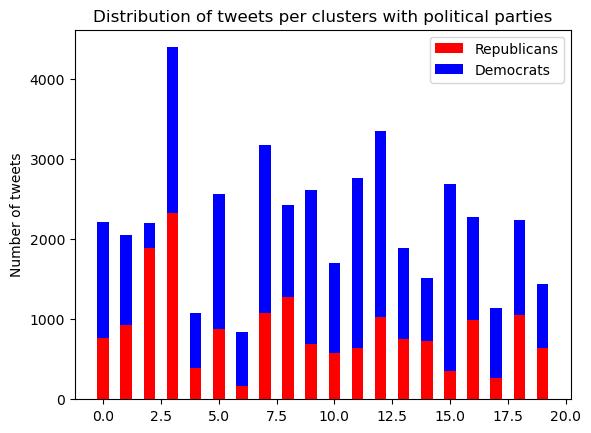

In [41]:
width = .5      # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(clusters, right_li, width, label='Republicans', color="r")
ax.bar(clusters, left_li, width, bottom=right_li,
       label='Democrats', color="b")

ax.set_ylabel('Number of tweets')
ax.set_title('Distribution of tweets per clusters with political parties')
ax.legend()

plt.show()

In [135]:
val = 18
topic = get_topic(val)
topic[0:30]

[('covid', 49),
 ('vaccine', 31),
 ('pandemic', 27),
 ('people', 12),
 ('vaccinated', 11),
 ('community', 8),
 ('relief', 8),
 ('check', 8),
 ('country', 8),
 ('worker', 7),
 ('health', 7),
 ('work', 7),
 ('public', 7),
 ('leader', 6),
 ('time', 6),
 ('thing', 6),
 ('need', 6),
 ('one', 5),
 ('family', 5),
 ('help', 5),
 ('make', 5),
 ('would', 5),
 ('million', 5),
 ('done', 5),
 ('even', 5),
 ('best', 5),
 ('enough', 4),
 ('want', 4),
 ('vote', 4),
 ('also', 4)]

In [122]:
def rank(k):
    dic = {}
    for cluster in range(k):
        left_count = int(frame.loc[frame['cluster']==cluster].loc[frame['party']=='left'].count()[0])
        right_count = int(frame.loc[frame['cluster']==cluster].loc[frame['party']=='right'].count()[0])
        score = left_count*right_count/(left_count+right_count)
        dic[cluster] = score
    sorted_dict = sorted([(value, key) for (key, value) in dic.items()], reverse=True)
    sorted_dict = [(v, k) for (k, v) in sorted_dict]
    return sorted_dict

rank(k)

[(1, 991.7217347706192),
 (17, 739.1517774343122),
 (15, 606.6651567944251),
 (6, 590.0114810562571),
 (0, 585.3465136054422),
 (19, 554.1591312056737),
 (9, 537.4061496099129),
 (11, 527.7790106333796),
 (12, 523.1176213379973),
 (13, 490.68884462151397),
 (5, 489.6084271703596),
 (7, 475.26772793053544),
 (4, 474.01283950617284),
 (2, 392.45438799076214),
 (18, 377.6190476190476),
 (16, 310.7244559203246),
 (14, 268.2105263157895),
 (8, 253.51493212669683),
 (3, 199.04418394950406),
 (10, 133.39879518072289)]

In [136]:
topic = 18

In [142]:
sub_frame = frame.loc[frame['cluster']==18]

In [143]:
sub_frame['Text'] = sub_frame['Text'].apply(lambda x: clean_stage3(x))

<ipython-input-143-a0f3da44d099>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_frame['Text'] = sub_frame['Text'].apply(lambda x: clean_stage3(x))


In [147]:
sub_frame = sub_frame.drop_duplicates()

In [235]:
sub_frame['Text'].values

array(['politician insisting politicize mass shooting enabled horrifying policy they take💰to uphold really just telling accept them. acceptable. they politicizing opposing common sense widely agreed upon public.',
       'change decision conditions. just with idea sending million free home covid test initially laughed happening. again. million will relief. time #cancelstudentdebt.',
       'thank birthday wish advice been pandemic almost whole time', ...,
       "need have very careful thorough vetting ensure we're keeping american safe.",
       'nine state recovered since coronavirus pandemic began republican governor #redstaterecovery',
       'state recovered since coronavirus pandemic began republican governor'],
      dtype=object)

In [182]:
#sub_text = sub_frame['Text'].values
#sub_labels = sub_frame['party'].values
#sub_vectors = [v for v,t in pair if t in sub_text]
#train_list = [(sub_vectors[i], sub_labels[i]) for i in range(len(sub_labels))]
#train_list[0:2]

sub_text = sub_frame['Text'].values
sub_pair = [(vectors[i], text[i]) for i in range(len(sub_text))]
sub_vectors = [v for v,t in sub_pair if t in sub_text]
sub_labels = sub_frame['party'].values
train_list = [(sub_vectors[i], sub_labels[i]) for i in range(len(sub_labels))]
len(sub_vectors)

1455

In [256]:
labels = frame['party'].values

In [257]:
clf = svm.SVC()
clf.fit(vectors,labels)

SVC()

In [258]:
# Testing it on the training data
prediction = clf.predict(sub_vectors)
confusion_matrix(sub_labels, prediction, normalize='true')

array([[0.95231608, 0.04768392],
       [0.94590846, 0.05409154]])

In [260]:
accuracy_score(sub_labels, prediction, normalize='true')

0.5072164948453608